In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
edits = pd.read_csv('../../data/external/edits.tsv', sep='\t')
edits.head(2)

,user_id,article_id,revision_id,namespace,timestamp,md5,reverted,reverted_user_id,reverted_revision_id,delta,cur_size
0,389427,9445560,279555872,0,2009-03-25 10:31:33,175d8a73b80b3c95719c458b698e5179,0,-1,-1,276,1661
1,389427,9445560,279556938,0,2009-03-25 10:41:09,48fa53402b2819283472a899a30117a1,0,-1,-1,97,1758


In [3]:
edits.shape

(22126031, 11)

# Initial analysis

In [4]:
edits['time'] = pd.to_datetime(edits.timestamp)

In [5]:
df = edits[['user_id', 'article_id', 'revision_id', 'time', 'reverted']]

In [6]:
users = df.user_id.unique()

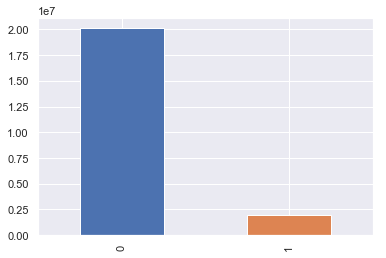

In [7]:
df.reverted.value_counts().plot.bar()

In [8]:
df.reverted.value_counts()

0    20136772
1     1989259
Name: reverted, dtype: int64

In [9]:
1989259/(20136772+1989259)

0.08990582178972813

In [10]:
print(df.time.min())
print(df.time.max())

2001-05-10 13:06:51
2010-08-31 23:59:55


In [11]:
edits_year = df.time.apply(lambda x: x.year)
edits_month = df.time.apply(lambda x: x.month)
edits_day = df.time.apply(lambda x: x.day)
edits_hours = df.time.apply(lambda x: x.hour)

Text(0.5, 1.0, 'Number of edits per year')

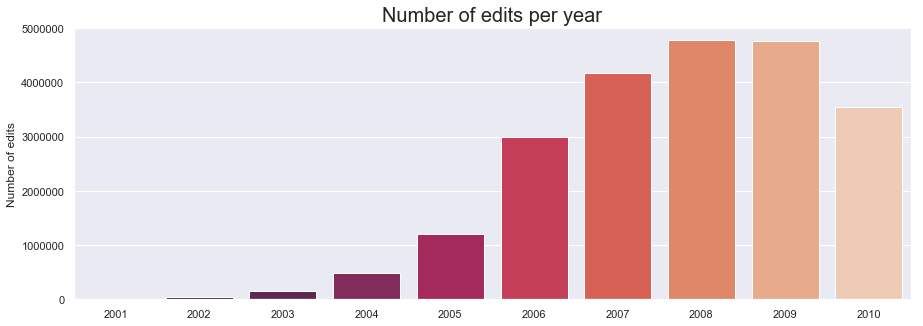

In [12]:
plt.figure(figsize=(15,5))

years = edits_year.value_counts()
sns.barplot(x=years.index, y=years.values, palette="rocket")
plt.ylabel('Number of edits')
plt.title('Number of edits per year', fontsize=20)

In [13]:
edits_year.value_counts()

2008    4771823
2009    4763174
2007    4170817
2010    3542105
2006    2987272
2005    1202262
2004     492729
2003     153074
2002      38870
2001       3905
Name: time, dtype: int64

In [14]:
print('Number of records of 2010 compared to 2009:', 3542105/4763174)
print('Number of months that the records considered in 2010:', 8/12)

Number of records of 2010 compared to 2009: 0.7436438391711073
Number of months that the records considered in 2010: 0.6666666666666666


In [15]:
df_year = pd.DataFrame(edits_year.value_counts())
df_year.reset_index(inplace=True)
df_year = df_year.rename(columns={'time': 'num_edits', 'index': 'year'})
df_year.sort_values(by='year', inplace=True)
df_year['num_edits_shifted'] = df_year.num_edits.shift(1)
df_year['increase'] = df_year['num_edits'] - df_year['num_edits_shifted']
df_year

,year,num_edits,num_edits_shifted,increase
9,2001,3905,NaN,NaN
8,2002,38870,3905.0,34965.0
7,2003,153074,38870.0,114204.0
6,2004,492729,153074.0,339655.0
5,2005,1202262,492729.0,709533.0
4,2006,2987272,1202262.0,1785010.0
2,2007,4170817,2987272.0,1183545.0
0,2008,4771823,4170817.0,601006.0
1,2009,4763174,4771823.0,-8649.0
3,2010,3542105,4763174.0,-1221069.0


Text(0.5, 1.0, 'Increase of edits from year before')

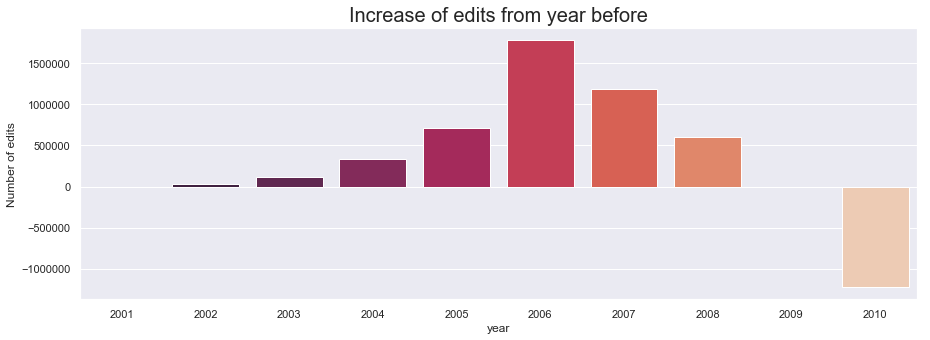

In [16]:
plt.figure(figsize=(15,5))

sns.barplot(x=df_year.year, y=df_year.increase, palette="rocket")
plt.ylabel('Number of edits')
plt.title('Increase of edits from year before', fontsize=20)

Text(0.5, 1.0, 'Increase of edits from year before')

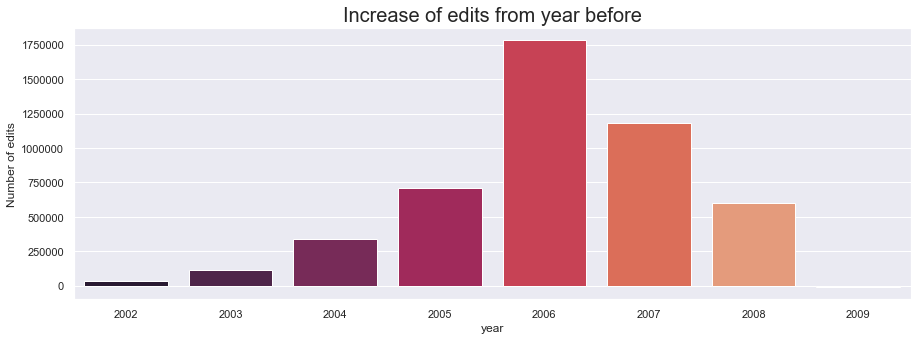

In [17]:
plt.figure(figsize=(15,5))

sns.barplot(x=df_year.year[1:-1], y=df_year.increase[1:-1], palette="rocket")
plt.ylabel('Number of edits')
plt.title('Increase of edits from year before', fontsize=20)

Text(0.5, 1.0, 'Number of edits per month')

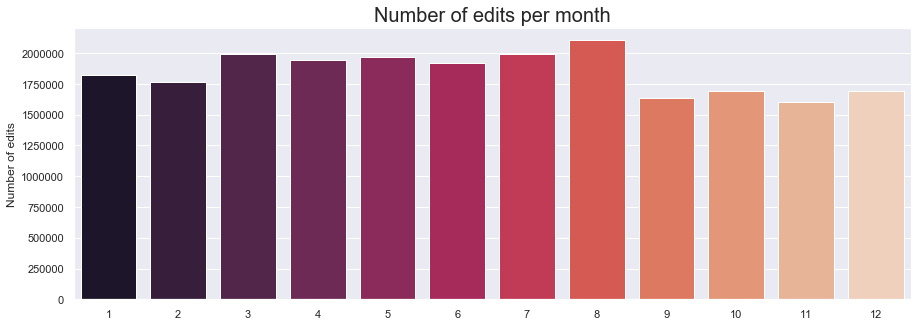

In [18]:
plt.figure(figsize=(15,5))

months = edits_month.value_counts()
sns.barplot(x=months.index, y=months.values, palette="rocket")
plt.ylabel('Number of edits')
plt.title('Number of edits per month', fontsize=20)

Text(0.5, 1.0, 'Number of edits per day of the month')

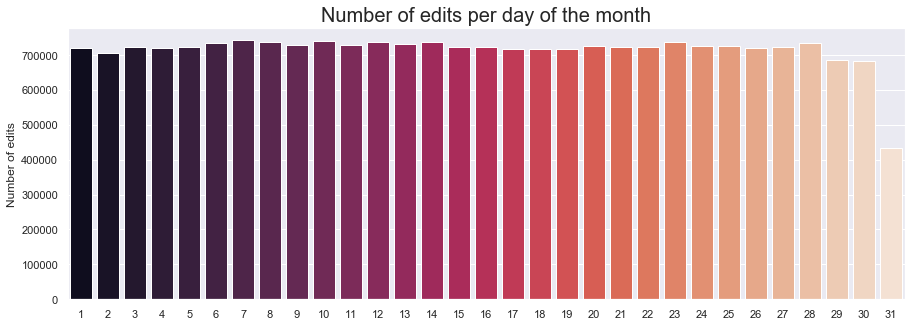

In [19]:
plt.figure(figsize=(15,5))

days = edits_day.value_counts()
sns.barplot(x=days.index, y=days.values, palette="rocket")
plt.ylabel('Number of edits')
plt.title('Number of edits per day of the month', fontsize=20)

Text(0.5, 1.0, 'Number of edits per hour of the day')

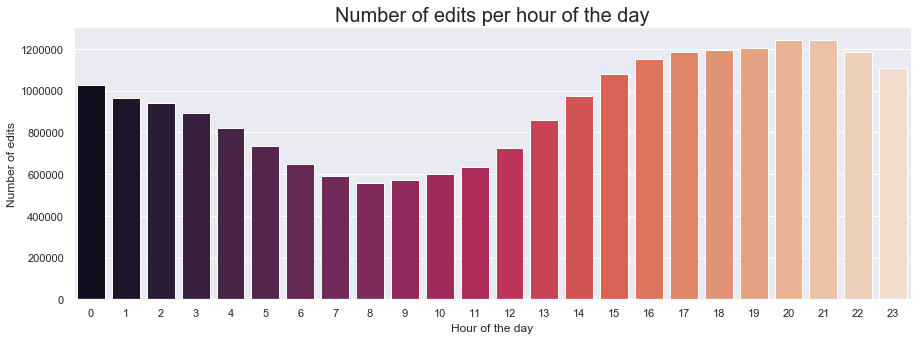

In [20]:
plt.figure(figsize=(15,5))

hours = edits_hours.value_counts()
sns.barplot(x=hours.index, y=hours.values, palette="rocket")
plt.ylabel('Number of edits')
plt.xlabel('Hour of the day')
plt.title('Number of edits per hour of the day', fontsize=20)

# Getting info from reverted updates

In [21]:
reverted = df[df.reverted==1]
reverted.head()

,user_id,article_id,revision_id,time,reverted
10,870433,1601117,30962488,2005-12-11 20:36:51,1
12,870433,241261,76627657,2006-09-19 18:26:11,1
42,870433,2816791,32225146,2005-12-21 11:19:58,1
43,870433,4599275,32003546,2005-12-19 20:14:33,1
45,870433,1681168,136024148,2007-06-05 09:54:21,1


In [22]:
revert_count = df[df.reverted==1].groupby(['user_id'])['time'].count()
revert_count = pd.DataFrame(revert_count)
revert_count = revert_count.rename(columns={'time': 'reverted_count'})
revert_count.head()

,reverted_count
user_id,
60,2
64,1
162,4
291,81
342,587


In [23]:
total_edits = df.groupby(['user_id'])['time'].count()
total_edits = pd.DataFrame(total_edits)
total_edits = total_edits.rename(columns={'time': 'total_edits'})
total_edits.head()

,total_edits
user_id,
30,1
44,33
54,1
60,14
64,33


In [24]:
df_reverts = pd.merge(revert_count, total_edits, how='left', on='user_id')
df_reverts.head()

,reverted_count,total_edits
user_id,,
60,2,14
64,1,33
162,4,119
291,81,875
342,587,4279


In [25]:
df_reverts['percent'] = df_reverts.reverted_count / df_reverts.total_edits

In [26]:
df_reverts.sort_values(by='reverted_count', ascending=False).head(10)

,reverted_count,total_edits,percent
user_id,,,
416473,59323,146134,0.405949
648946,41003,153038,0.267927
362055,38254,74780,0.511554
607561,31263,59100,0.528985
937923,29067,334173,0.086982
631125,24963,65046,0.383775
955857,22287,72858,0.305896
524959,21262,110794,0.191906
798815,18525,58578,0.316245


In [27]:
df_reverts.sort_values(by='percent', ascending=False).head(10)

,reverted_count,total_edits,percent
user_id,,,
587979,1,1,1.0
34726,1,1,1.0
329926,1,1,1.0
860788,1,1,1.0
858646,1,1,1.0
858084,1,1,1.0
338563,1,1,1.0
855274,1,1,1.0
340286,1,1,1.0


In [28]:
print('Mean number of reverts per user:', df_reverts.reverted_count.mean())
print('Std of reverts per user:', df_reverts.reverted_count.std())
print('Max number of reverts per user:', df_reverts.reverted_count.max())
print('Mean percent of reverts per user:', df_reverts.percent.mean())
print('Std percent of reverts per user:', df_reverts.percent.std())
print('Max percent of reverts per user:', df_reverts.percent.max())

Mean number of reverts per user: 134.14653719063998
Std of reverts per user: 1063.9261897892998
Max number of reverts per user: 59323
Mean percent of reverts per user: 0.09126681989201095
Std percent of reverts per user: 0.13782604460746703
Max percent of reverts per user: 1.0


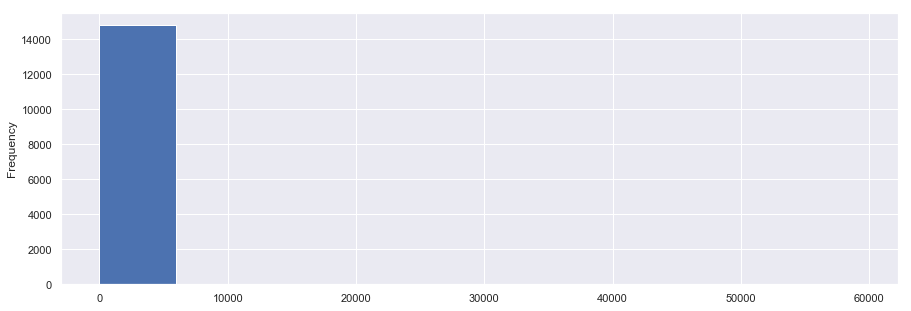

In [29]:
plt.figure(figsize=(15,5))

df_reverts.reverted_count.plot.hist()

Text(0, 0.5, 'Num of edits')

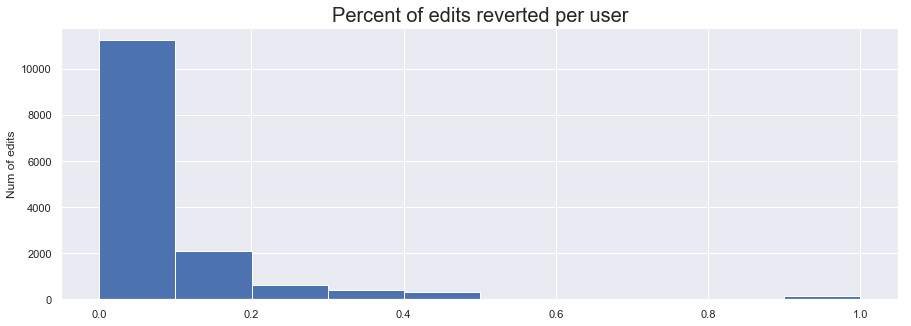

In [30]:
plt.figure(figsize=(15,5))
df_reverts.percent.plot.hist()
plt.title('Percent of edits reverted per user', fontsize=20)
plt.ylabel('Num of edits')